In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra

using FenrirForNeuro
using ModelingToolkit
using OrdinaryDiffEq

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        push!(dfs, df)
    end
    return dfs
end

function simulate(prob, p, proj)
    tₛ, tₑ = prob.tspan
    sol = solve(
        remake(prob, p=p),
        RadauIIA5(),
        abstol=1e-14,
        reltol=1e-14,
        dense=false,
    )
    t_obs = sol.t[1:end]
    u_obs = vcat([(proj * u) for u in sol.u]...)
    return t_obs, u_obs
end


d_norm(X, y) = sqrt.(sum(((X .- y) ./ y) .^ 2, dims=[2]))

d_norm (generic function with 1 method)

In [3]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 3.25 # inches
PT_PER_INCH = 72

72

In [4]:
RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

"../../figures/"

In [5]:
@parameters α β # γ δ
θ = [α => 1.5, β => 1.0]#, γ => 3.0, δ => 1.0]
prob_prior, prob = get_LV(θ)
proj = [1 0]

observation = generate_data(prob, proj, 1e-1, 1e-2)

(t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.0], u = [[0.9067300985526126], [1.314988624734509], [1.3134746362803318], [1.5006321396343512], [1.081558690200021], [1.3472460331563232], [1.1728608193063108], [0.5156004331947965], [1.1737341817796187], [1.5517142829873434]  …  [0.7408600696637382], [0.9441168430513248], [0.7849518951510559], [1.0026054105325082], [0.9759616319326417], [1.6305038418401656], [1.1405272067758154], [1.0180383022060269], [1.0028723505878177], [0.9234020000577787]])

In [6]:
PATH = RESULTS_PATH * "lv/2p/lv/fenrir/tempered_diff/"
opt_fnames = readdir.(PATH)

trajectories = import_csvs(PATH, opt_fnames, [:α, :β, :κ², :l, :T])

PATH = RESULTS_PATH * "lv/2p/lv/fenrir/loss_surface"
loss_surface_fnames = filter(x -> !occursin("grad", x), readdir.(PATH))
sort_fnames(fnames) = fnames[sortperm([parse(Int64, split(split(fname, "-")[end-1], "_")[end]) for fname in fnames])]
loss_surface_fnames = sort_fnames(loss_surface_fnames)

loss_surface_sections = import_csvs(PATH, loss_surface_fnames)

tempering_schedule = reverse([10.0^x for x in 0:20])
header = ["α", "β", [@sprintf("NLL(κ²=%1.e)", κ²) for κ² in tempering_schedule]...]

loss_surface = vcat(loss_surface_sections...)
rename!(loss_surface, header)

function get_conv_metrics(trajectories, θ)
    θ_keys = map(x -> Symbol(x[1]), θ)
    θ_true = map(x -> x[2], θ)
    last_rows = get_last_rows(trajectories)
    θ_est = last_rows[!, θ_keys]
    dₚ = reshape(d_norm(Array(θ_est), θ_true'), :)
    conv = dₚ .< 5e-2
    return dₚ, conv
end

BASE_PATH = RESULTS_PATH * "lv/2p/lv/"

θ_keys = map(x -> Symbol(x[1]), θ)
θ_true = map(x -> x[2], θ)

lb, ub = get_prior_bounds(prob_prior)

((α = 0.001, β = 0.001), (α = 5.0, β = 5.0))

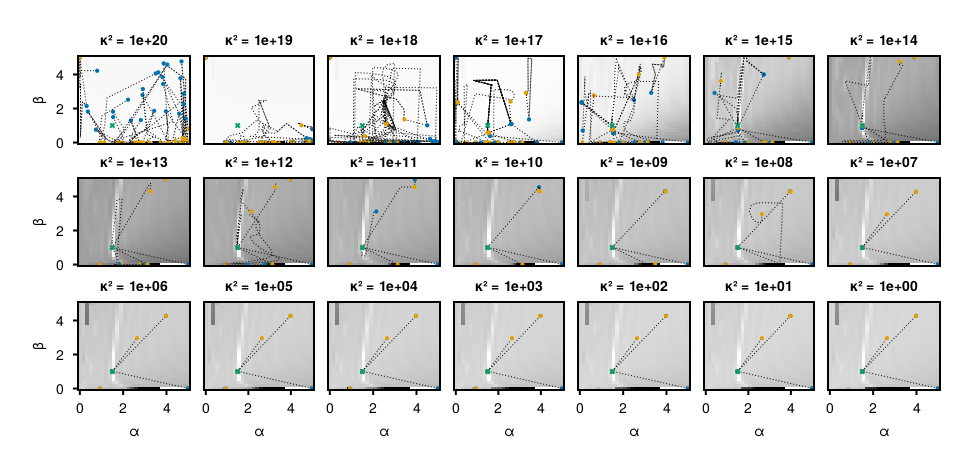

In [16]:
nll = reshape(Array(loss_surface[:, 3:end]), (30, 30, 21))
nll = nll[:, :, 1:end]
gNa_range = sort(unique(Array(loss_surface[:, 1])))
gK_range = sort(unique(Array(loss_surface[:, 2])))

f = Figure(size=(PT_PER_INCH * FULL_WIDTH, PT_PER_INCH * HEIGHT))
for (i, κ²) in enumerate(tempering_schedule)
    title = @sprintf("κ² = %1.e", κ²)
    ax = Axis(f[Int64(floor((i - 1) / 7))+1, ((i-1)%7)], xlabel="α", ylabel="β", title=title, titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)


    # prepare data
    t_at_κ² = [t[log.(t[!, :κ²]).==log.(κ²), :] for t in trajectories]

    # plot
    norm_nll = log10.(nll[:, :, i])
    norm_nll = (norm_nll .- minimum(filter(!isnan, norm_nll))) ./ (maximum(filter(!isnan, norm_nll)) - minimum(filter(!isnan, norm_nll)))
    heatmap!(ax, gNa_range, gK_range, norm_nll, colormap=reverse(cgrad(:greys)), colorrange=(0, 0.4), highclip=:black)
    for t in t_at_κ²[1:25]
        if size(t)[1] > 0
            lines!(ax, t[!, :α], t[!, :β], linewidth=0.5, color=:black, linestyle=:dot)
            scatter!(ax, t[1, :α], t[1, :β], color=Makie.wong_colors()[1], markersize=3)
            scatter!(ax, t[end, :α], t[end, :β], color=Makie.wong_colors()[2], markersize=3)
        end
    end
    scatter!(ax, θ_true..., color=Makie.wong_colors()[3], markersize=4, marker=:x)

    # fmt
    hidey = ((i - 1) % 7) != 0
    hidex = Int64(floor((i - 1) / 7)) + 1 != 3
    hidexdecorations!(ax, label=hidex, ticks=hidex, ticklabels=hidex)
    hideydecorations!(ax, label=hidey, ticks=hidey, ticklabels=hidey)
end

colgap!(f.layout, 7)
rowgap!(f.layout, 5)

f

In [17]:
save(joinpath(FIGURES_PATH, "appendix_figure2a.pdf"), f, overwrite=true)

CairoMakie.Screen{IMAGE}


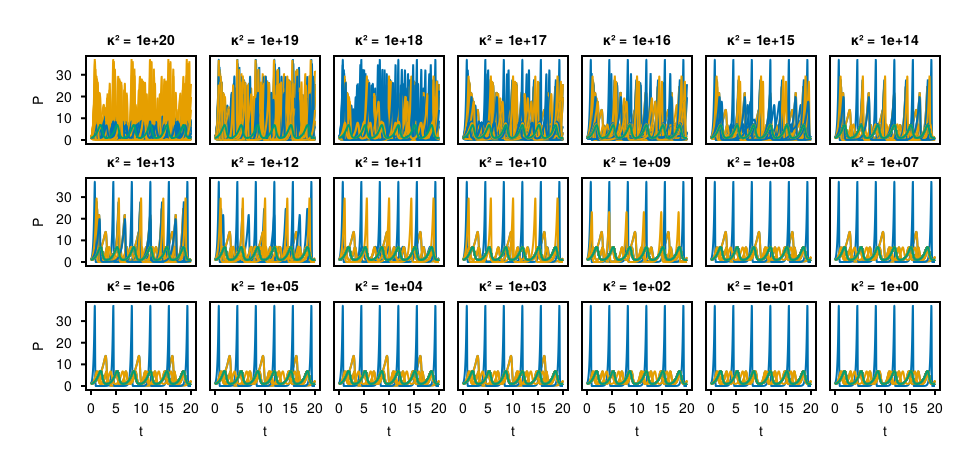

In [18]:
f = Figure(size=(PT_PER_INCH * FULL_WIDTH, PT_PER_INCH * HEIGHT))

for (i, κ²) in enumerate(tempering_schedule)
    title = @sprintf("κ² = %1.e", κ²)
    ax = Axis(f[Int64(floor((i - 1) / 7))+1, ((i-1)%7)], xlabel="t", ylabel="P", title=title, titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)


    # prepare data
    t_at_κ² = [t[log.(t[!, :κ²]).==log.(κ²), :] for t in trajectories]

    # plot
    for t in t_at_κ²[1:25]
        line_cmap = :bluesreds
        if size(t)[1] > 0
            t_1st, y_1st = simulate(prob, t[1, [:α, :β]], proj)
            t_last, y_last = simulate(prob, t[end, [:α, :β]], proj)
            lines!(ax, t_1st, y_1st, color=Makie.wong_colors()[1], linewidth=1)
            lines!(ax, t_last, y_last, color=Makie.wong_colors()[2], linewidth=1)
        end
    end
    
    
    t_true, y_true = simulate(prob, θ_true, proj)
    lines!(ax, t_true, y_true, color=Makie.wong_colors()[3], markersize=4, marker=:x, linewidth=1)

    # fmt
    hidey = ((i - 1) % 7) != 0
    hidex = Int64(floor((i - 1) / 7)) + 1 != 3
    hidexdecorations!(ax, label=hidex, ticks=hidex, ticklabels=hidex)
    hideydecorations!(ax, label=hidey, ticks=hidey, ticklabels=hidey)
end

colgap!(f.layout, 7)
rowgap!(f.layout, 5)

f

In [21]:
save(joinpath(FIGURES_PATH, "appendix_figure2b.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}
